In [1]:
from google.colab import files
uploaded = files.upload()

Saving Input.mp4 to Input.mp4


In [1]:
ls

Animals_out.avi  Image186.jpg  Image274.jpg  Image362.jpg  Image450.jpg
Animals_out.mp4  Image187.jpg  Image275.jpg  Image363.jpg  Image451.jpg
datalab/         Image188.jpg  Image276.jpg  Image364.jpg  Image452.jpg
Image0.jpg       Image189.jpg  Image277.jpg  Image365.jpg  Image453.jpg
Image100.jpg     Image18.jpg   Image278.jpg  Image366.jpg  Image454.jpg
Image101.jpg     Image190.jpg  Image279.jpg  Image367.jpg  Image455.jpg
Image102.jpg     Image191.jpg  Image27.jpg   Image368.jpg  Image456.jpg
Image103.jpg     Image192.jpg  Image280.jpg  Image369.jpg  Image457.jpg
Image104.jpg     Image193.jpg  Image281.jpg  Image36.jpg   Image458.jpg
Image105.jpg     Image194.jpg  Image282.jpg  Image370.jpg  Image459.jpg
Image106.jpg     Image195.jpg  Image283.jpg  Image371.jpg  Image45.jpg
Image107.jpg     Image196.jpg  Image284.jpg  Image372.jpg  Image460.jpg
Image108.jpg     Image197.jpg  Image285.jpg  Image373.jpg  Image461.jpg
Image109.jpg     Image198.jpg  Image286.jpg  Image374.jpg  Image4

In [0]:
!rm -rf /content

In [2]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    #img_path = sys.argv[1]
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # print('x:',x)
    x = preprocess_input(x)
    print("preprocess",x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    loss = K.sum(model.layers[-1].output)
    #conv_output = [l for l in model.layers[0].layers if l.name is layer_name][0].output
    conv_output = [l for l in model.layers if l.name == layer_name][0].output
    #print(conv_output)

    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)
    
    cv2.imwrite("image.jpg", image)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

#preprocessed_input = load_image('cat_dog.jpg')
#preprocessed_input = load_image("./examples/boat.jpg")

#print('preprocessed_input:',preprocessed_input)

model = VGG16(weights='imagenet')

model.summary()


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

preprocess [[[[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  ...

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.93

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text(0.5,1,'Guided Grad-CAM for Bull mastiff (Top prediction)')

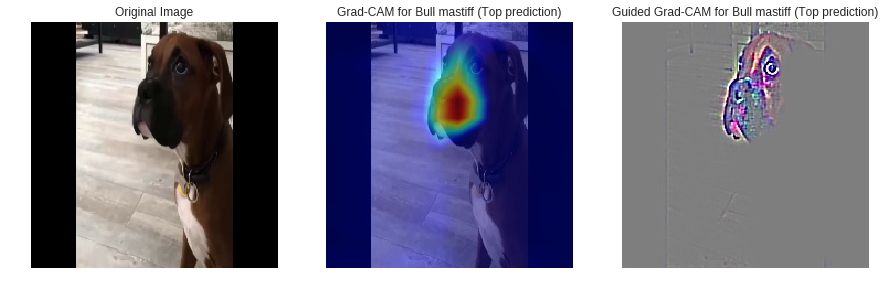

In [0]:
preprocessed_input = load_image('cat_dog.jpg')

predictions = model.predict(preprocessed_input)
top_1 = decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

#print(predictions.shape)
topK = 20
decoded = decode_predictions(predictions, top=topK)[0]
#print('Predicted:', decoded)



predicted_class = np.argmax(predictions)
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")
cv2.imwrite("gradcam.jpg", cam)

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))

from matplotlib import pyplot as plt
from skimage import io
from skimage.transform import resize
fig, axs = plt.subplots(1,3,figsize=(15,5))

img = io.imread('cat_dog.jpg')
image = resize(img, (224, 224))
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Original Image')

img = io.imread('gradcam.jpg')
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Grad-CAM for Bull mastiff (Top prediction)')

img = io.imread('guided_gradcam.jpg')
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title('Guided Grad-CAM for Bull mastiff (Top prediction)')

In [0]:
!apt-get install ffmpeg x264 libx264-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dbus i965-va-driver libaacs0 libapparmor1 libasound2 libasound2-data libass9
  libasyncns0 libavc1394-0 libavcodec57 libavdevice57 libavfilter6
  libavformat57 libavresample3 libavutil55 libbdplus0 libbluray2
  libboost-filesystem1.62.0 libboost-system1.62.0 libbs2b0 libcaca0 libcairo2
  libcapnp-0.5.3 libcdio-cdda1 libcdio-paranoia1 libcdio13 libchromaprint1
  libcrystalhd3 libdbus-1-3 libdc1394-22 libdrm-amdgpu1 libdrm-common
  libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libdrm2 libegl1-mesa libelf1
  libffms2-4 libfftw3-double3 libflac8 libflite1 libfribidi0 libgbm1
  libgl1-mesa-dri libgl1-mesa-glx libglapi-mesa libglu1-mesa libgme0 libgpac4
  libgraphite2-3 libgsm1 libharfbuzz0b libiec61883-0 libjack-jackd2-0
  libllvm5.0 libmirclient9 libmircommon7 libmircore1 libmirprotobuf3
  libmp3lame0 libmpg123-0 libnuma1 libogg0 libopenal-da

Get:32 http://archive.ubuntu.com/ubuntu artful/main amd64 libpixman-1-0 amd64 0.34.0-1 [230 kB]
Get:33 http://archive.ubuntu.com/ubuntu artful/main amd64 libxcb-render0 amd64 1.12-1ubuntu1 [14.8 kB]
Get:34 http://archive.ubuntu.com/ubuntu artful/main amd64 libxcb-shm0 amd64 1.12-1ubuntu1 [5,482 B]
Get:35 http://archive.ubuntu.com/ubuntu artful/main amd64 libcairo2 amd64 1.14.10-1ubuntu1 [558 kB]
Get:36 http://archive.ubuntu.com/ubuntu artful/main amd64 libtheora0 amd64 1.1.1+dfsg.1-14 [170 kB]
Get:37 http://archive.ubuntu.com/ubuntu artful/universe amd64 libtwolame0 amd64 0.3.13-2 [46.1 kB]
Get:38 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libvorbis0a amd64 1.3.5-4ubuntu0.2 [86.5 kB]
Get:39 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libvorbisenc2 amd64 1.3.5-4ubuntu0.2 [70.6 kB]
Get:40 http://archive.ubuntu.com/ubuntu artful/main amd64 libvpx4 amd64 1.6.1-3 [763 kB]
Get:41 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwavpack1 amd64 5.1.0

Get:103 http://archive.ubuntu.com/ubuntu artful/universe amd64 libopenal1 amd64 1:1.17.2-4 [207 kB]
Get:104 http://archive.ubuntu.com/ubuntu artful/main amd64 libasyncns0 amd64 0.8-6 [12.1 kB]
Get:105 http://archive.ubuntu.com/ubuntu artful/main amd64 libflac8 amd64 1.3.2-1 [213 kB]
Get:106 http://archive.ubuntu.com/ubuntu artful/main amd64 libsndfile1 amd64 1.0.28-4 [169 kB]
Get:107 http://archive.ubuntu.com/ubuntu artful/main amd64 libwrap0 amd64 7.6.q-26 [46.1 kB]
Get:108 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libpulse0 amd64 1:10.0-2ubuntu3.1 [265 kB]
Get:109 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwayland-client0 amd64 1.14.0-1ubuntu0.1 [22.5 kB]
Get:110 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwayland-cursor0 amd64 1.14.0-1ubuntu0.1 [9,890 B]
Get:111 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libwayland-server0 amd64 1.14.0-1ubuntu0.1 [28.5 kB]
Get:112 http://archive.ubuntu.com/ubuntu artful-updates/ma

Get:140 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 mesa-vdpau-drivers amd64 17.2.8-0ubuntu0~17.10.1 [1,658 kB]
Get:141 http://archive.ubuntu.com/ubuntu artful/main amd64 tcpd amd64 7.6.q-26 [23.5 kB]
Get:142 http://archive.ubuntu.com/ubuntu artful/universe amd64 i965-va-driver amd64 1.8.3-1ubuntu1 [633 kB]
Get:143 http://archive.ubuntu.com/ubuntu artful/universe amd64 va-driver-all amd64 1.8.3-2 [4,294 B]
Get:144 http://archive.ubuntu.com/ubuntu artful/main amd64 vdpau-driver-all amd64 1.1.1-3ubuntu1 [4,674 B]
Get:145 http://archive.ubuntu.com/ubuntu artful/universe amd64 x264 amd64 2:0.148.2795+gitaaa9aa8-1 [77.4 kB]
Get:146 http://archive.ubuntu.com/ubuntu artful/main amd64 libtxc-dxtn-s2tc amd64 1.0+git20151227-2 [48.4 kB]
Fetched 62.4 MB in 13s (4,663 kB/s)
Extracting templates from packages: 100%
Selecting previously unselected package libgsm1:amd64.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../000-libgsm1_1.0.13-4

Selecting previously unselected package libopenjp2-7:amd64.
Preparing to unpack .../024-libopenjp2-7_2.2.0-1_amd64.deb ...
Unpacking libopenjp2-7:amd64 (2.2.0-1) ...
Selecting previously unselected package libopus0:amd64.
Preparing to unpack .../025-libopus0_1.1.2-1ubuntu1_amd64.deb ...
Unpacking libopus0:amd64 (1.1.2-1ubuntu1) ...
Selecting previously unselected package libshine3:amd64.
Preparing to unpack .../026-libshine3_3.1.1-1_amd64.deb ...
Unpacking libshine3:amd64 (3.1.1-1) ...
Selecting previously unselected package libsnappy1v5:amd64.
Preparing to unpack .../027-libsnappy1v5_1.1.6-4_amd64.deb ...
Unpacking libsnappy1v5:amd64 (1.1.6-4) ...
Selecting previously unselected package libspeex1:amd64.
Preparing to unpack .../028-libspeex1_1.2~rc1.2-1ubuntu1_amd64.deb ...
Unpacking libspeex1:amd64 (1.2~rc1.2-1ubuntu1) ...
Selecting previously unselected package libsoxr0:amd64.
Preparing to unpack .../029-libsoxr0_0.1.2-2_amd64.deb ...
Unpacking libsoxr0:amd64 (0.1.2-2) ...
Selecting 

Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../053-libgraphite2-3_1.3.10-2_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.10-2) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../054-libharfbuzz0b_1.4.2-1_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (1.4.2-1) ...
Selecting previously unselected package libass9:amd64.
Preparing to unpack .../055-libass9_1%3a0.13.7-2_amd64.deb ...
Unpacking libass9:amd64 (1:0.13.7-2) ...
Selecting previously unselected package libbluray2:amd64.
Preparing to unpack .../056-libbluray2_1%3a1.0.1.deb1-2_amd64.deb ...
Unpacking libbluray2:amd64 (1:1.0.1.deb1-2) ...
Selecting previously unselected package libchromaprint1:amd64.
Preparing to unpack .../057-libchromaprint1_1.4.2-1_amd64.deb ...
Unpacking libchromaprint1:amd64 (1.4.2-1) ...
Selecting previously unselected package libgme0:amd64.
Preparing to unpack .../058-libgme0_0.6.1-1_amd64.deb ...
Unpacking libgme0:amd64 (0.6.1-1) 

Selecting previously unselected package libglapi-mesa:amd64.
Preparing to unpack .../081-libglapi-mesa_17.2.8-0ubuntu0~17.10.1_amd64.deb ...
Unpacking libglapi-mesa:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Selecting previously unselected package libx11-xcb1:amd64.
Preparing to unpack .../082-libx11-xcb1_2%3a1.6.4-3_amd64.deb ...
Unpacking libx11-xcb1:amd64 (2:1.6.4-3) ...
Selecting previously unselected package libxcb-dri2-0:amd64.
Preparing to unpack .../083-libxcb-dri2-0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-dri2-0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-dri3-0:amd64.
Preparing to unpack .../084-libxcb-dri3-0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-dri3-0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-glx0:amd64.
Preparing to unpack .../085-libxcb-glx0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-glx0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-present0:amd64.
Preparing to unpack .../086-li

Selecting previously unselected package libwayland-server0:amd64.
Preparing to unpack .../110-libwayland-server0_1.14.0-1ubuntu0.1_amd64.deb ...
Unpacking libwayland-server0:amd64 (1.14.0-1ubuntu0.1) ...
Selecting previously unselected package libgbm1:amd64.
Preparing to unpack .../111-libgbm1_17.2.8-0ubuntu0~17.10.1_amd64.deb ...
Unpacking libgbm1:amd64 (17.2.8-0ubuntu0~17.10.1) ...
Selecting previously unselected package libboost-system1.62.0:amd64.
Preparing to unpack .../112-libboost-system1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-system1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libcapnp-0.5.3:amd64.
Preparing to unpack .../113-libcapnp-0.5.3_0.5.3-2ubuntu2_amd64.deb ...
Unpacking libcapnp-0.5.3:amd64 (0.5.3-2ubuntu2) ...
Selecting previously unselected package libboost-filesystem1.62.0:amd64.
Preparing to unpack .../114-libboost-filesystem1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-filesystem1.62.0:amd64 (1.62.0

Selecting previously unselected package tcpd.
Preparing to unpack .../140-tcpd_7.6.q-26_amd64.deb ...
Unpacking tcpd (7.6.q-26) ...
Selecting previously unselected package i965-va-driver:amd64.
Preparing to unpack .../141-i965-va-driver_1.8.3-1ubuntu1_amd64.deb ...
Unpacking i965-va-driver:amd64 (1.8.3-1ubuntu1) ...
Selecting previously unselected package va-driver-all:amd64.
Preparing to unpack .../142-va-driver-all_1.8.3-2_amd64.deb ...
Unpacking va-driver-all:amd64 (1.8.3-2) ...
Selecting previously unselected package vdpau-driver-all:amd64.
Preparing to unpack .../143-vdpau-driver-all_1.1.1-3ubuntu1_amd64.deb ...
Unpacking vdpau-driver-all:amd64 (1.1.1-3ubuntu1) ...
Selecting previously unselected package x264.
Preparing to unpack .../144-x264_2%3a0.148.2795+gitaaa9aa8-1_amd64.deb ...
Unpacking x264 (2:0.148.2795+gitaaa9aa8-1) ...
Selecting previously unselected package libtxc-dxtn-s2tc:amd64.
Preparing to unpack .../145-libtxc-dxtn-s2tc_1.0+git20151227-2_amd64.deb ...
Unpacking li

Setting up libprotobuf-lite10:amd64 (3.0.0-9ubuntu5) ...
Setting up libmpg123-0:amd64 (1.25.6-1) ...
Setting up libslang2:amd64 (2.3.1-5ubuntu1) ...
Setting up libwayland-cursor0:amd64 (1.14.0-1ubuntu0.1) ...
Setting up libgsm1:amd64 (1.0.13-4) ...
Setting up libxrandr2:amd64 (2:1.5.1-1) ...
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up libboost-system1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libwrap0:amd64 (7.6.q-26) ...
Setting up libwayland-server0:amd64 (1.14.0-1ubuntu0.1) ...
Setting up libwebp6:amd64 (0.6.0-3) ...
Setting up libvorbisfile3:amd64 (1.3.5-4ubuntu0.2) ...
Setting up libx264-dev:amd64 (2:0.148.2795+gitaaa9aa8-1) ...
Setting up libcairo2:amd64 (1.14.10-1ubuntu1) ...
Setting up libopencv-core3.1:amd64 (3.1.0+dfsg1-1~exp1ubuntu3) ...
Setting up libopenmpt0:amd64 (0.2.8760~beta27-1) ...
Setting up libmirprotobuf3:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Setting up libflite1:amd64 (2.0.0-release-4) ...
Setting up libflac8:amd64 (1.3.2-1) ...
Se

In [3]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
!pip install -q tqdm
from tqdm import tqdm


video_inp = 'Input.mp4'
video_out = 'Animals_out.avi'

video_reader = cv2.VideoCapture(video_inp)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
#print(nb_frames)
#print(frame_h)
#print(frame_w)

video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               20.0, 
                               (frame_w, frame_h))

for i in tqdm(range(nb_frames)):
    ret, image = video_reader.read()
    if ret == True:
      #preprocessed_input = load_image(image)
      #original_input = load_original_image(image)
      input_image = ''
      input_image = cv2.resize(image, (224, 224))
      #input_image = input_image / 255.
      input_image = input_image[:,:,::-1]
      input_image = np.expand_dims(input_image, 0)
      #input_image = preprocess_input(input_image)
      #cv2.imwrite('Image' + str(i) + '.jpg',input_image)
      predictions = model.predict(input_image)
      top_1 = decode_predictions(predictions)[0][0]
      print('Predicted class:')
      print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))
      
      predicted_class = np.argmax(predictions)
      
      #input_image = np.expand_dims(input_image, 0)
      #input_image = input_image / 255.
      #input_image = preprocess_input(input_image)
      
      
      
      #print("preprocess" + str(i) ,input_image)

      #predictions = model.predict([input_image, dummy_array])

      #predictions = model.predict(input_image)
      #top_1 = decode_predictions(predictions)[0][0]
      #print('Predicted class:')
      #print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

      #print("predicted_class", predicted_class)
      cam, heatmap = grad_cam(model, input_image, predicted_class, "block5_conv3")
      cv2.imwrite('Image' + str(i) + '.jpg', cam)
      video_writer.write(cam)

"""
    boxes = decode_netout(netout[0], 
                          obj_threshold=0.3,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    image = draw_boxes(image, boxes, labels=LABELS)
"""

    
    
video_reader.release()
video_writer.release()

  0%|          | 1/481 [00:01<11:24,  1.43s/it]

Predicted class:
zebra (n02391049) with probability 0.46


  0%|          | 2/481 [00:01<06:30,  1.23it/s]

Predicted class:
zebra (n02391049) with probability 0.55
Predicted class:
zebra (n02391049) with probability 0.65


  1%|          | 4/481 [00:02<04:04,  1.95it/s]

Predicted class:
zebra (n02391049) with probability 0.46


  1%|          | 5/481 [00:02<03:35,  2.21it/s]

Predicted class:
zebra (n02391049) with probability 0.56


  1%|          | 6/481 [00:02<03:16,  2.42it/s]

Predicted class:
zebra (n02391049) with probability 0.55
Predicted class:
zebra (n02391049) with probability 0.68


  2%|▏         | 8/481 [00:03<02:57,  2.66it/s]

Predicted class:
zebra (n02391049) with probability 0.71


  2%|▏         | 9/481 [00:03<02:49,  2.79it/s]

Predicted class:
zebra (n02391049) with probability 0.42


  2%|▏         | 10/481 [00:03<02:42,  2.90it/s]

Predicted class:
zebra (n02391049) with probability 0.60


  2%|▏         | 11/481 [00:03<02:37,  2.99it/s]

Predicted class:
zebra (n02391049) with probability 0.66


  2%|▏         | 12/481 [00:03<02:32,  3.07it/s]

Predicted class:
zebra (n02391049) with probability 0.51


  3%|▎         | 13/481 [00:04<02:29,  3.13it/s]

Predicted class:
zebra (n02391049) with probability 0.36


  3%|▎         | 14/481 [00:04<02:27,  3.17it/s]

Predicted class:
zebra (n02391049) with probability 0.43
Predicted class:
zebra (n02391049) with probability 0.31


  3%|▎         | 15/481 [00:04<02:25,  3.20it/s]

Predicted class:
zebra (n02391049) with probability 0.70


  3%|▎         | 16/481 [00:04<02:23,  3.24it/s]

Predicted class:
zebra (n02391049) with probability 0.52


  4%|▎         | 17/481 [00:05<02:21,  3.27it/s]

Predicted class:
zebra (n02391049) with probability 0.33


  4%|▎         | 18/481 [00:05<02:20,  3.29it/s]

Predicted class:
zebra (n02391049) with probability 0.46


  4%|▍         | 19/481 [00:05<02:19,  3.32it/s]

Predicted class:
zebra (n02391049) with probability 0.28


  4%|▍         | 20/481 [00:05<02:18,  3.33it/s]

Predicted class:
zebra (n02391049) with probability 0.16


  4%|▍         | 21/481 [00:06<02:17,  3.35it/s]

Predicted class:
zebra (n02391049) with probability 0.39


  5%|▍         | 22/481 [00:06<02:16,  3.37it/s]

Predicted class:
zebra (n02391049) with probability 0.31


  5%|▍         | 23/481 [00:06<02:15,  3.38it/s]

Predicted class:
zebra (n02391049) with probability 0.22


  5%|▍         | 24/481 [00:07<02:14,  3.39it/s]

Predicted class:
flatworm (n01924916) with probability 0.20


  5%|▌         | 25/481 [00:07<02:13,  3.40it/s]

Predicted class:
flatworm (n01924916) with probability 0.18


  5%|▌         | 26/481 [00:07<02:13,  3.42it/s]

Predicted class:
zebra (n02391049) with probability 0.17


  6%|▌         | 27/481 [00:07<02:12,  3.43it/s]

Predicted class:
electric_ray (n01496331) with probability 0.13


  6%|▌         | 28/481 [00:08<02:12,  3.43it/s]

Predicted class:
hippopotamus (n02398521) with probability 0.17


  6%|▌         | 29/481 [00:08<02:11,  3.43it/s]

Predicted class:
tiger (n02129604) with probability 0.18


  6%|▌         | 30/481 [00:08<02:11,  3.44it/s]

Predicted class:
electric_ray (n01496331) with probability 0.15


  6%|▋         | 31/481 [00:09<02:10,  3.44it/s]

Predicted class:
electric_ray (n01496331) with probability 0.17


  7%|▋         | 32/481 [00:09<02:10,  3.44it/s]

Predicted class:
electric_ray (n01496331) with probability 0.15


  7%|▋         | 33/481 [00:09<02:10,  3.44it/s]

Predicted class:
tiger (n02129604) with probability 0.17


  7%|▋         | 34/481 [00:09<02:09,  3.44it/s]

Predicted class:
tiger (n02129604) with probability 0.17


  7%|▋         | 35/481 [00:10<02:09,  3.44it/s]

Predicted class:
tiger (n02129604) with probability 0.11


  7%|▋         | 36/481 [00:10<02:09,  3.44it/s]

Predicted class:
electric_ray (n01496331) with probability 0.15


  8%|▊         | 37/481 [00:10<02:08,  3.44it/s]

Predicted class:
electric_ray (n01496331) with probability 0.12


  8%|▊         | 38/481 [00:11<02:08,  3.44it/s]

Predicted class:
tiger (n02129604) with probability 0.14


  8%|▊         | 39/481 [00:11<02:09,  3.42it/s]

Predicted class:
tiger (n02129604) with probability 0.17


  8%|▊         | 40/481 [00:11<02:09,  3.42it/s]

Predicted class:
tiger (n02129604) with probability 0.25


  9%|▊         | 41/481 [00:12<02:08,  3.41it/s]

Predicted class:
electric_ray (n01496331) with probability 0.13


  9%|▊         | 42/481 [00:12<02:08,  3.41it/s]

Predicted class:
electric_ray (n01496331) with probability 0.13


  9%|▉         | 43/481 [00:12<02:08,  3.41it/s]

Predicted class:
tiger (n02129604) with probability 0.14


  9%|▉         | 44/481 [00:12<02:08,  3.40it/s]

Predicted class:
tiger (n02129604) with probability 0.20


  9%|▉         | 45/481 [00:13<02:08,  3.39it/s]

Predicted class:
flatworm (n01924916) with probability 0.24


 10%|▉         | 46/481 [00:13<02:08,  3.39it/s]

Predicted class:
zebra (n02391049) with probability 0.20


 10%|▉         | 47/481 [00:13<02:08,  3.39it/s]

Predicted class:
tiger (n02129604) with probability 0.32


 10%|▉         | 48/481 [00:14<02:08,  3.38it/s]

Predicted class:
tiger (n02129604) with probability 0.14


 10%|█         | 49/481 [00:14<02:08,  3.37it/s]

Predicted class:
tiger (n02129604) with probability 0.19


 10%|█         | 50/481 [00:14<02:08,  3.37it/s]

Predicted class:
zebra (n02391049) with probability 0.12


 11%|█         | 51/481 [00:15<02:08,  3.36it/s]

Predicted class:
zebra (n02391049) with probability 0.15


 11%|█         | 52/481 [00:15<02:08,  3.35it/s]

Predicted class:
zebra (n02391049) with probability 0.16


 11%|█         | 53/481 [00:15<02:07,  3.34it/s]

Predicted class:
zebra (n02391049) with probability 0.30


 11%|█         | 54/481 [00:16<02:07,  3.34it/s]

Predicted class:
zebra (n02391049) with probability 0.47


 11%|█▏        | 55/481 [00:16<02:07,  3.33it/s]

Predicted class:
zebra (n02391049) with probability 0.20


 12%|█▏        | 56/481 [00:16<02:07,  3.32it/s]

Predicted class:
zebra (n02391049) with probability 0.24


 12%|█▏        | 57/481 [00:17<02:07,  3.32it/s]

Predicted class:
zebra (n02391049) with probability 0.37


 12%|█▏        | 58/481 [00:17<02:07,  3.31it/s]

Predicted class:
zebra (n02391049) with probability 0.44


 12%|█▏        | 59/481 [00:17<02:07,  3.30it/s]

Predicted class:
zebra (n02391049) with probability 0.50


 12%|█▏        | 60/481 [00:18<02:07,  3.29it/s]

Predicted class:
zebra (n02391049) with probability 0.52


 13%|█▎        | 61/481 [00:18<02:07,  3.29it/s]

Predicted class:
zebra (n02391049) with probability 0.51


 13%|█▎        | 62/481 [00:18<02:07,  3.28it/s]

Predicted class:
zebra (n02391049) with probability 0.40


 13%|█▎        | 63/481 [00:19<02:07,  3.27it/s]

Predicted class:
zebra (n02391049) with probability 0.56


 13%|█▎        | 64/481 [00:19<02:07,  3.26it/s]

Predicted class:
zebra (n02391049) with probability 0.58


 14%|█▎        | 65/481 [00:19<02:07,  3.25it/s]

Predicted class:
zebra (n02391049) with probability 0.43


 14%|█▎        | 66/481 [00:20<02:07,  3.24it/s]

Predicted class:
zebra (n02391049) with probability 0.69


 14%|█▍        | 67/481 [00:20<02:07,  3.24it/s]

Predicted class:
zebra (n02391049) with probability 0.64


 14%|█▍        | 68/481 [00:21<02:07,  3.23it/s]

Predicted class:
zebra (n02391049) with probability 0.73


 14%|█▍        | 69/481 [00:21<02:07,  3.22it/s]

Predicted class:
zebra (n02391049) with probability 0.60


 15%|█▍        | 70/481 [00:21<02:07,  3.21it/s]

Predicted class:
zebra (n02391049) with probability 0.61


 15%|█▍        | 71/481 [00:22<02:08,  3.19it/s]

Predicted class:
zebra (n02391049) with probability 0.55


 15%|█▍        | 72/481 [00:22<02:08,  3.18it/s]

Predicted class:
zebra (n02391049) with probability 0.40


 15%|█▌        | 73/481 [00:23<02:08,  3.17it/s]

Predicted class:
flatworm (n01924916) with probability 0.53


 15%|█▌        | 74/481 [00:23<02:08,  3.16it/s]

Predicted class:
flatworm (n01924916) with probability 0.39


 16%|█▌        | 75/481 [00:23<02:08,  3.15it/s]

Predicted class:
flatworm (n01924916) with probability 0.52


 16%|█▌        | 76/481 [00:24<02:08,  3.14it/s]

Predicted class:
flatworm (n01924916) with probability 0.51


 16%|█▌        | 77/481 [00:24<02:08,  3.13it/s]

Predicted class:
zebra (n02391049) with probability 0.48


 16%|█▌        | 78/481 [00:24<02:08,  3.12it/s]

Predicted class:
zebra (n02391049) with probability 0.69


 16%|█▋        | 79/481 [00:25<02:09,  3.12it/s]

Predicted class:
zebra (n02391049) with probability 0.75


 17%|█▋        | 80/481 [00:25<02:09,  3.11it/s]

Predicted class:
zebra (n02391049) with probability 0.83


 17%|█▋        | 81/481 [00:26<02:09,  3.10it/s]

Predicted class:
zebra (n02391049) with probability 0.82


 17%|█▋        | 82/481 [00:26<02:09,  3.09it/s]

Predicted class:
zebra (n02391049) with probability 0.72


 17%|█▋        | 83/481 [00:26<02:09,  3.08it/s]

Predicted class:
zebra (n02391049) with probability 0.88


 17%|█▋        | 84/481 [00:27<02:09,  3.07it/s]

Predicted class:
zebra (n02391049) with probability 0.79


 18%|█▊        | 85/481 [00:27<02:09,  3.06it/s]

Predicted class:
zebra (n02391049) with probability 0.84


 18%|█▊        | 86/481 [00:28<02:09,  3.06it/s]

Predicted class:
zebra (n02391049) with probability 0.85


 18%|█▊        | 87/481 [00:28<02:09,  3.05it/s]

Predicted class:
zebra (n02391049) with probability 0.80


 18%|█▊        | 88/481 [00:28<02:09,  3.04it/s]

Predicted class:
zebra (n02391049) with probability 0.82


 19%|█▊        | 89/481 [00:29<02:09,  3.03it/s]

Predicted class:
zebra (n02391049) with probability 0.74


 19%|█▊        | 90/481 [00:29<02:09,  3.02it/s]

Predicted class:
zebra (n02391049) with probability 0.75


 19%|█▉        | 91/481 [00:30<02:09,  3.01it/s]

Predicted class:
zebra (n02391049) with probability 0.70


 19%|█▉        | 92/481 [00:30<02:09,  3.00it/s]

Predicted class:
zebra (n02391049) with probability 0.74


 19%|█▉        | 93/481 [00:31<02:09,  2.99it/s]

Predicted class:
zebra (n02391049) with probability 0.80


 20%|█▉        | 94/481 [00:31<02:09,  2.98it/s]

Predicted class:
zebra (n02391049) with probability 0.83


 20%|█▉        | 95/481 [00:31<02:09,  2.97it/s]

Predicted class:
zebra (n02391049) with probability 0.85


 20%|█▉        | 96/481 [00:32<02:09,  2.96it/s]

Predicted class:
zebra (n02391049) with probability 0.87


 20%|██        | 97/481 [00:32<02:10,  2.95it/s]

Predicted class:
zebra (n02391049) with probability 0.89


 20%|██        | 98/481 [00:33<02:10,  2.94it/s]

Predicted class:
zebra (n02391049) with probability 0.85


 21%|██        | 99/481 [00:33<02:10,  2.93it/s]

Predicted class:
zebra (n02391049) with probability 0.93


 21%|██        | 100/481 [00:34<02:10,  2.92it/s]

Predicted class:
zebra (n02391049) with probability 0.92


 21%|██        | 101/481 [00:34<02:10,  2.91it/s]

Predicted class:
zebra (n02391049) with probability 0.81


 21%|██        | 102/481 [00:35<02:10,  2.90it/s]

Predicted class:
zebra (n02391049) with probability 0.83


 21%|██▏       | 103/481 [00:35<02:10,  2.90it/s]

Predicted class:
zebra (n02391049) with probability 0.81


 22%|██▏       | 104/481 [00:36<02:10,  2.89it/s]

Predicted class:
zebra (n02391049) with probability 0.72


 22%|██▏       | 105/481 [00:36<02:10,  2.88it/s]

Predicted class:
zebra (n02391049) with probability 0.71


 22%|██▏       | 106/481 [00:37<02:11,  2.86it/s]

Predicted class:
zebra (n02391049) with probability 0.63


 22%|██▏       | 107/481 [00:37<02:11,  2.85it/s]

Predicted class:
zebra (n02391049) with probability 0.73


 22%|██▏       | 108/481 [00:37<02:11,  2.84it/s]

Predicted class:
zebra (n02391049) with probability 0.74


 23%|██▎       | 109/481 [00:38<02:11,  2.83it/s]

Predicted class:
zebra (n02391049) with probability 0.57


 23%|██▎       | 110/481 [00:38<02:11,  2.83it/s]

Predicted class:
zebra (n02391049) with probability 0.57


 23%|██▎       | 111/481 [00:39<02:11,  2.82it/s]

Predicted class:
zebra (n02391049) with probability 0.53


 23%|██▎       | 112/481 [00:39<02:11,  2.81it/s]

Predicted class:
zebra (n02391049) with probability 0.72


 23%|██▎       | 113/481 [00:40<02:11,  2.80it/s]

Predicted class:
zebra (n02391049) with probability 0.68


 24%|██▎       | 114/481 [00:40<02:11,  2.79it/s]

Predicted class:
zebra (n02391049) with probability 0.68


 24%|██▍       | 115/481 [00:41<02:11,  2.78it/s]

Predicted class:
zebra (n02391049) with probability 0.69


 24%|██▍       | 116/481 [00:41<02:11,  2.78it/s]

Predicted class:
zebra (n02391049) with probability 0.60


 24%|██▍       | 117/481 [00:42<02:11,  2.77it/s]

Predicted class:
zebra (n02391049) with probability 0.36


 25%|██▍       | 118/481 [00:42<02:11,  2.76it/s]

Predicted class:
tiger (n02129604) with probability 0.51


 25%|██▍       | 119/481 [00:43<02:11,  2.75it/s]

Predicted class:
tiger (n02129604) with probability 0.56


 25%|██▍       | 120/481 [00:43<02:11,  2.74it/s]

Predicted class:
tiger (n02129604) with probability 0.47


 25%|██▌       | 121/481 [00:44<02:11,  2.73it/s]

Predicted class:
tiger (n02129604) with probability 0.55


 25%|██▌       | 122/481 [00:44<02:11,  2.73it/s]

Predicted class:
tiger (n02129604) with probability 0.51


 26%|██▌       | 123/481 [00:45<02:11,  2.72it/s]

Predicted class:
tiger (n02129604) with probability 0.29


 26%|██▌       | 124/481 [00:45<02:11,  2.71it/s]

Predicted class:
barracouta (n02514041) with probability 0.17


 26%|██▌       | 125/481 [00:46<02:11,  2.70it/s]

Predicted class:
barracouta (n02514041) with probability 0.19


 26%|██▌       | 126/481 [00:46<02:11,  2.69it/s]

Predicted class:
tiger (n02129604) with probability 0.65


 26%|██▋       | 127/481 [00:47<02:11,  2.68it/s]

Predicted class:
tiger (n02129604) with probability 0.63


 27%|██▋       | 128/481 [00:47<02:11,  2.68it/s]

Predicted class:
tiger_cat (n02123159) with probability 0.40


 27%|██▋       | 129/481 [00:48<02:11,  2.67it/s]

Predicted class:
tiger (n02129604) with probability 0.44


 27%|██▋       | 130/481 [00:48<02:12,  2.66it/s]

Predicted class:
tiger_cat (n02123159) with probability 0.39


 27%|██▋       | 131/481 [00:49<02:12,  2.65it/s]

Predicted class:
tiger_cat (n02123159) with probability 0.37


 27%|██▋       | 132/481 [00:49<02:11,  2.64it/s]

Predicted class:
zebra (n02391049) with probability 0.37


 28%|██▊       | 133/481 [00:50<02:11,  2.64it/s]

Predicted class:
tiger_cat (n02123159) with probability 0.46


 28%|██▊       | 134/481 [00:50<02:11,  2.63it/s]

Predicted class:
tiger_cat (n02123159) with probability 0.57


 28%|██▊       | 135/481 [00:51<02:11,  2.62it/s]

Predicted class:
tiger_cat (n02123159) with probability 0.50


 28%|██▊       | 136/481 [00:52<02:12,  2.61it/s]

Predicted class:
tiger_cat (n02123159) with probability 0.48


 28%|██▊       | 137/481 [00:52<02:12,  2.60it/s]

Predicted class:
tiger_cat (n02123159) with probability 0.46


 29%|██▊       | 138/481 [00:53<02:12,  2.60it/s]

Predicted class:
tiger_cat (n02123159) with probability 0.40


 29%|██▉       | 139/481 [00:53<02:12,  2.59it/s]

Predicted class:
tiger (n02129604) with probability 0.45


 29%|██▉       | 140/481 [00:54<02:12,  2.58it/s]

Predicted class:
tiger (n02129604) with probability 0.61


 29%|██▉       | 141/481 [00:54<02:12,  2.57it/s]

Predicted class:
tiger (n02129604) with probability 0.52


 30%|██▉       | 142/481 [00:55<02:12,  2.57it/s]

Predicted class:
tiger (n02129604) with probability 0.53


 30%|██▉       | 143/481 [00:55<02:12,  2.56it/s]

Predicted class:
tiger (n02129604) with probability 0.50


 30%|██▉       | 144/481 [00:56<02:12,  2.55it/s]

Predicted class:
tiger (n02129604) with probability 0.36


 30%|███       | 145/481 [00:56<02:12,  2.54it/s]

Predicted class:
zebra (n02391049) with probability 0.41


 30%|███       | 146/481 [00:57<02:12,  2.54it/s]

Predicted class:
zebra (n02391049) with probability 0.41


 31%|███       | 147/481 [00:58<02:12,  2.53it/s]

Predicted class:
zebra (n02391049) with probability 0.37


 31%|███       | 148/481 [00:58<02:12,  2.52it/s]

Predicted class:
zebra (n02391049) with probability 0.36


 31%|███       | 149/481 [00:59<02:12,  2.51it/s]

Predicted class:
zebra (n02391049) with probability 0.44


 31%|███       | 150/481 [01:00<02:12,  2.50it/s]

Predicted class:
zebra (n02391049) with probability 0.31


 31%|███▏      | 151/481 [01:00<02:12,  2.49it/s]

Predicted class:
zebra (n02391049) with probability 0.28


 32%|███▏      | 152/481 [01:01<02:12,  2.48it/s]

Predicted class:
tiger (n02129604) with probability 0.24


 32%|███▏      | 153/481 [01:01<02:12,  2.48it/s]

Predicted class:
zebra (n02391049) with probability 0.38


 32%|███▏      | 154/481 [01:02<02:12,  2.47it/s]

Predicted class:
zebra (n02391049) with probability 0.34


 32%|███▏      | 155/481 [01:02<02:12,  2.46it/s]

Predicted class:
tiger (n02129604) with probability 0.35


 32%|███▏      | 156/481 [01:03<02:12,  2.46it/s]

Predicted class:
tiger (n02129604) with probability 0.40


 33%|███▎      | 157/481 [01:04<02:12,  2.45it/s]

Predicted class:
tiger (n02129604) with probability 0.39


 33%|███▎      | 158/481 [01:04<02:12,  2.44it/s]

Predicted class:
tiger (n02129604) with probability 0.31


 33%|███▎      | 159/481 [01:05<02:12,  2.43it/s]

Predicted class:
tiger (n02129604) with probability 0.34


 33%|███▎      | 160/481 [01:05<02:12,  2.43it/s]

Predicted class:
tiger (n02129604) with probability 0.41


 33%|███▎      | 161/481 [01:06<02:12,  2.42it/s]

Predicted class:
tiger (n02129604) with probability 0.49


 34%|███▎      | 162/481 [01:07<02:12,  2.41it/s]

Predicted class:
tiger (n02129604) with probability 0.43


 34%|███▍      | 163/481 [01:07<02:12,  2.41it/s]

Predicted class:
tiger (n02129604) with probability 0.48


 34%|███▍      | 164/481 [01:08<02:12,  2.40it/s]

Predicted class:
tiger (n02129604) with probability 0.57


 34%|███▍      | 165/481 [01:08<02:12,  2.39it/s]

Predicted class:
ant (n02219486) with probability 0.29


 35%|███▍      | 166/481 [01:09<02:12,  2.39it/s]

Predicted class:
ant (n02219486) with probability 0.29


 35%|███▍      | 167/481 [01:10<02:12,  2.38it/s]

Predicted class:
bee (n02206856) with probability 0.32


 35%|███▍      | 168/481 [01:10<02:12,  2.37it/s]

Predicted class:
ant (n02219486) with probability 0.29


 35%|███▌      | 169/481 [01:11<02:11,  2.36it/s]

Predicted class:
ant (n02219486) with probability 0.28


 35%|███▌      | 170/481 [01:12<02:11,  2.36it/s]

Predicted class:
ant (n02219486) with probability 0.33


 36%|███▌      | 171/481 [01:12<02:11,  2.35it/s]

Predicted class:
ant (n02219486) with probability 0.32


 36%|███▌      | 172/481 [01:13<02:11,  2.34it/s]

Predicted class:
bee (n02206856) with probability 0.31


 36%|███▌      | 173/481 [01:14<02:11,  2.34it/s]

Predicted class:
bee (n02206856) with probability 0.31


 36%|███▌      | 174/481 [01:14<02:11,  2.33it/s]

Predicted class:
bee (n02206856) with probability 0.30


 36%|███▋      | 175/481 [01:15<02:11,  2.32it/s]

Predicted class:
ant (n02219486) with probability 0.32


 37%|███▋      | 176/481 [01:15<02:11,  2.32it/s]

Predicted class:
ant (n02219486) with probability 0.32


 37%|███▋      | 177/481 [01:16<02:11,  2.31it/s]

Predicted class:
ant (n02219486) with probability 0.28


 37%|███▋      | 178/481 [01:17<02:11,  2.30it/s]

Predicted class:
bee (n02206856) with probability 0.22


 37%|███▋      | 179/481 [01:17<02:11,  2.30it/s]

Predicted class:
bee (n02206856) with probability 0.22


 37%|███▋      | 180/481 [01:18<02:11,  2.29it/s]

Predicted class:
bee (n02206856) with probability 0.19


 38%|███▊      | 181/481 [01:19<02:11,  2.28it/s]

Predicted class:
bee (n02206856) with probability 0.19


 38%|███▊      | 182/481 [01:19<02:11,  2.28it/s]

Predicted class:
bee (n02206856) with probability 0.22


 38%|███▊      | 183/481 [01:20<02:11,  2.27it/s]

Predicted class:
bee (n02206856) with probability 0.31


 38%|███▊      | 184/481 [01:21<02:11,  2.27it/s]

Predicted class:
bee (n02206856) with probability 0.25


 38%|███▊      | 185/481 [01:21<02:11,  2.26it/s]

Predicted class:
bee (n02206856) with probability 0.25


 39%|███▊      | 186/481 [01:22<02:10,  2.25it/s]

Predicted class:
bee (n02206856) with probability 0.25


 39%|███▉      | 187/481 [01:23<02:10,  2.25it/s]

Predicted class:
bee (n02206856) with probability 0.23


 39%|███▉      | 188/481 [01:23<02:10,  2.24it/s]

Predicted class:
bee (n02206856) with probability 0.26


 39%|███▉      | 189/481 [01:24<02:10,  2.23it/s]

Predicted class:
bee (n02206856) with probability 0.26


 40%|███▉      | 190/481 [01:25<02:10,  2.23it/s]

Predicted class:
bee (n02206856) with probability 0.24


 40%|███▉      | 191/481 [01:26<02:10,  2.22it/s]

Predicted class:
bee (n02206856) with probability 0.24


 40%|███▉      | 192/481 [01:26<02:10,  2.21it/s]

Predicted class:
bee (n02206856) with probability 0.22


 40%|████      | 193/481 [01:27<02:10,  2.21it/s]

Predicted class:
bee (n02206856) with probability 0.21


 40%|████      | 194/481 [01:28<02:10,  2.20it/s]

Predicted class:
bee (n02206856) with probability 0.23


 41%|████      | 195/481 [01:28<02:10,  2.20it/s]

Predicted class:
feather_boa (n03325584) with probability 0.18


 41%|████      | 196/481 [01:29<02:10,  2.19it/s]

Predicted class:
feather_boa (n03325584) with probability 0.19


 41%|████      | 197/481 [01:30<02:09,  2.19it/s]

Predicted class:
feather_boa (n03325584) with probability 0.18


 41%|████      | 198/481 [01:30<02:09,  2.18it/s]

Predicted class:
feather_boa (n03325584) with probability 0.22


 41%|████▏     | 199/481 [01:31<02:09,  2.17it/s]

Predicted class:
feather_boa (n03325584) with probability 0.30


 42%|████▏     | 200/481 [01:32<02:09,  2.17it/s]

Predicted class:
feather_boa (n03325584) with probability 0.27


 42%|████▏     | 201/481 [01:32<02:09,  2.16it/s]

Predicted class:
feather_boa (n03325584) with probability 0.27


 42%|████▏     | 202/481 [01:33<02:09,  2.16it/s]

Predicted class:
feather_boa (n03325584) with probability 0.21


 42%|████▏     | 203/481 [01:34<02:09,  2.15it/s]

Predicted class:
feather_boa (n03325584) with probability 0.19


 42%|████▏     | 204/481 [01:35<02:09,  2.14it/s]

Predicted class:
feather_boa (n03325584) with probability 0.22


 43%|████▎     | 205/481 [01:35<02:09,  2.14it/s]

Predicted class:
feather_boa (n03325584) with probability 0.18


 43%|████▎     | 206/481 [01:36<02:09,  2.13it/s]

Predicted class:
feather_boa (n03325584) with probability 0.18


 43%|████▎     | 207/481 [01:37<02:08,  2.12it/s]

Predicted class:
feather_boa (n03325584) with probability 0.20


 43%|████▎     | 208/481 [01:38<02:08,  2.12it/s]

Predicted class:
feather_boa (n03325584) with probability 0.16


 43%|████▎     | 209/481 [01:38<02:08,  2.11it/s]

Predicted class:
bee (n02206856) with probability 0.16


 44%|████▎     | 210/481 [01:39<02:08,  2.11it/s]

Predicted class:
bee (n02206856) with probability 0.20


 44%|████▍     | 211/481 [01:40<02:08,  2.10it/s]

Predicted class:
bee (n02206856) with probability 0.19


 44%|████▍     | 212/481 [01:41<02:08,  2.10it/s]

Predicted class:
bee (n02206856) with probability 0.17


 44%|████▍     | 213/481 [01:41<02:08,  2.09it/s]

Predicted class:
feather_boa (n03325584) with probability 0.15


 44%|████▍     | 214/481 [01:42<02:08,  2.08it/s]

Predicted class:
feather_boa (n03325584) with probability 0.17


 45%|████▍     | 215/481 [01:43<02:07,  2.08it/s]

Predicted class:
feather_boa (n03325584) with probability 0.20


 45%|████▍     | 216/481 [01:44<02:07,  2.07it/s]

Predicted class:
feather_boa (n03325584) with probability 0.20


 45%|████▌     | 217/481 [01:44<02:07,  2.07it/s]

Predicted class:
feather_boa (n03325584) with probability 0.16


 45%|████▌     | 218/481 [01:45<02:07,  2.06it/s]

Predicted class:
feather_boa (n03325584) with probability 0.18


 46%|████▌     | 219/481 [01:46<02:07,  2.06it/s]

Predicted class:
feather_boa (n03325584) with probability 0.21


 46%|████▌     | 220/481 [01:47<02:07,  2.05it/s]

Predicted class:
feather_boa (n03325584) with probability 0.19


 46%|████▌     | 221/481 [01:48<02:07,  2.04it/s]

Predicted class:
feather_boa (n03325584) with probability 0.20


 46%|████▌     | 222/481 [01:48<02:07,  2.04it/s]

Predicted class:
feather_boa (n03325584) with probability 0.20


 46%|████▋     | 223/481 [01:49<02:06,  2.03it/s]

Predicted class:
feather_boa (n03325584) with probability 0.24


 47%|████▋     | 224/481 [01:50<02:06,  2.03it/s]

Predicted class:
bee (n02206856) with probability 0.17


 47%|████▋     | 225/481 [01:51<02:06,  2.02it/s]

Predicted class:
bee (n02206856) with probability 0.21


 47%|████▋     | 226/481 [01:52<02:06,  2.02it/s]

Predicted class:
bee (n02206856) with probability 0.21


 47%|████▋     | 227/481 [01:52<02:06,  2.01it/s]

Predicted class:
bee (n02206856) with probability 0.23


 47%|████▋     | 228/481 [01:53<02:06,  2.01it/s]

Predicted class:
bee (n02206856) with probability 0.20


 48%|████▊     | 229/481 [01:54<02:06,  2.00it/s]

Predicted class:
bee (n02206856) with probability 0.24


 48%|████▊     | 230/481 [01:55<02:05,  1.99it/s]

Predicted class:
bee (n02206856) with probability 0.22


 48%|████▊     | 231/481 [01:56<02:05,  1.99it/s]

Predicted class:
bee (n02206856) with probability 0.22


 48%|████▊     | 232/481 [01:57<02:05,  1.98it/s]

Predicted class:
bee (n02206856) with probability 0.23


 48%|████▊     | 233/481 [01:57<02:05,  1.98it/s]

Predicted class:
feather_boa (n03325584) with probability 0.23


 49%|████▊     | 234/481 [01:58<02:05,  1.97it/s]

Predicted class:
bee (n02206856) with probability 0.20


 49%|████▉     | 235/481 [01:59<02:05,  1.97it/s]

Predicted class:
feather_boa (n03325584) with probability 0.26


 49%|████▉     | 236/481 [02:00<02:04,  1.96it/s]

Predicted class:
feather_boa (n03325584) with probability 0.27


 49%|████▉     | 237/481 [02:01<02:04,  1.96it/s]

Predicted class:
feather_boa (n03325584) with probability 0.24


 49%|████▉     | 238/481 [02:01<02:04,  1.95it/s]

Predicted class:
feather_boa (n03325584) with probability 0.22


 50%|████▉     | 239/481 [02:02<02:04,  1.95it/s]

Predicted class:
feather_boa (n03325584) with probability 0.22


 50%|████▉     | 240/481 [02:03<02:04,  1.94it/s]

Predicted class:
feather_boa (n03325584) with probability 0.19


 50%|█████     | 241/481 [02:04<02:03,  1.94it/s]

Predicted class:
feather_boa (n03325584) with probability 0.19


 50%|█████     | 242/481 [02:05<02:03,  1.93it/s]

Predicted class:
feather_boa (n03325584) with probability 0.19


 51%|█████     | 243/481 [02:06<02:03,  1.93it/s]

Predicted class:
bee (n02206856) with probability 0.20


 51%|█████     | 244/481 [02:07<02:03,  1.92it/s]

Predicted class:
bee (n02206856) with probability 0.25


 51%|█████     | 245/481 [02:07<02:03,  1.92it/s]

Predicted class:
bee (n02206856) with probability 0.25


 51%|█████     | 246/481 [02:08<02:03,  1.91it/s]

Predicted class:
bee (n02206856) with probability 0.24


 51%|█████▏    | 247/481 [02:09<02:02,  1.91it/s]

Predicted class:
ant (n02219486) with probability 0.18


 52%|█████▏    | 248/481 [02:10<02:02,  1.90it/s]

Predicted class:
bee (n02206856) with probability 0.19


 52%|█████▏    | 249/481 [02:11<02:02,  1.90it/s]

Predicted class:
bee (n02206856) with probability 0.21


 52%|█████▏    | 250/481 [02:12<02:02,  1.89it/s]

Predicted class:
feather_boa (n03325584) with probability 0.17


 52%|█████▏    | 251/481 [02:13<02:01,  1.89it/s]

Predicted class:
feather_boa (n03325584) with probability 0.19


 52%|█████▏    | 252/481 [02:14<02:01,  1.88it/s]

Predicted class:
bee (n02206856) with probability 0.19


 53%|█████▎    | 253/481 [02:14<02:01,  1.88it/s]

Predicted class:
feather_boa (n03325584) with probability 0.18


 53%|█████▎    | 254/481 [02:15<02:01,  1.87it/s]

Predicted class:
bee (n02206856) with probability 0.18


 53%|█████▎    | 255/481 [02:16<02:01,  1.87it/s]

Predicted class:
bee (n02206856) with probability 0.17


 53%|█████▎    | 256/481 [02:17<02:00,  1.86it/s]

Predicted class:
bee (n02206856) with probability 0.18


 53%|█████▎    | 257/481 [02:18<02:00,  1.86it/s]

Predicted class:
feather_boa (n03325584) with probability 0.17


 54%|█████▎    | 258/481 [02:19<02:00,  1.85it/s]

Predicted class:
feather_boa (n03325584) with probability 0.15


 54%|█████▍    | 259/481 [02:20<02:00,  1.85it/s]

Predicted class:
feather_boa (n03325584) with probability 0.15


 54%|█████▍    | 260/481 [02:21<01:59,  1.84it/s]

Predicted class:
feather_boa (n03325584) with probability 0.20


 54%|█████▍    | 261/481 [02:22<01:59,  1.84it/s]

Predicted class:
feather_boa (n03325584) with probability 0.20


 54%|█████▍    | 262/481 [02:22<01:59,  1.83it/s]

Predicted class:
feather_boa (n03325584) with probability 0.15


 55%|█████▍    | 263/481 [02:23<01:59,  1.83it/s]

Predicted class:
feather_boa (n03325584) with probability 0.18


 55%|█████▍    | 264/481 [02:24<01:58,  1.82it/s]

Predicted class:
feather_boa (n03325584) with probability 0.18


 55%|█████▌    | 265/481 [02:25<01:58,  1.82it/s]

Predicted class:
feather_boa (n03325584) with probability 0.20


 55%|█████▌    | 266/481 [02:26<01:58,  1.81it/s]

Predicted class:
feather_boa (n03325584) with probability 0.19


 56%|█████▌    | 267/481 [02:27<01:58,  1.81it/s]

Predicted class:
feather_boa (n03325584) with probability 0.14


 56%|█████▌    | 268/481 [02:28<01:57,  1.81it/s]

Predicted class:
bee (n02206856) with probability 0.15


 56%|█████▌    | 269/481 [02:29<01:57,  1.80it/s]

Predicted class:
bee (n02206856) with probability 0.14


 56%|█████▌    | 270/481 [02:30<01:57,  1.80it/s]

Predicted class:
feather_boa (n03325584) with probability 0.15


 56%|█████▋    | 271/481 [02:31<01:57,  1.79it/s]

Predicted class:
feather_boa (n03325584) with probability 0.15


 57%|█████▋    | 272/481 [02:32<01:56,  1.79it/s]

Predicted class:
bee (n02206856) with probability 0.13


 57%|█████▋    | 273/481 [02:33<01:56,  1.78it/s]

Predicted class:
bee (n02206856) with probability 0.18


 57%|█████▋    | 274/481 [02:34<01:56,  1.78it/s]

Predicted class:
bee (n02206856) with probability 0.20


 57%|█████▋    | 275/481 [02:35<01:56,  1.77it/s]

Predicted class:
bee (n02206856) with probability 0.22


 57%|█████▋    | 276/481 [02:36<01:56,  1.77it/s]

Predicted class:
bee (n02206856) with probability 0.22


 58%|█████▊    | 277/481 [02:37<01:55,  1.76it/s]

Predicted class:
bee (n02206856) with probability 0.13


 58%|█████▊    | 278/481 [02:38<01:55,  1.76it/s]

Predicted class:
bee (n02206856) with probability 0.14


 58%|█████▊    | 279/481 [02:39<01:55,  1.75it/s]

Predicted class:
bee (n02206856) with probability 0.17


 58%|█████▊    | 280/481 [02:40<01:54,  1.75it/s]

Predicted class:
bee (n02206856) with probability 0.14


 58%|█████▊    | 281/481 [02:41<01:54,  1.74it/s]

Predicted class:
bee (n02206856) with probability 0.14


 59%|█████▊    | 282/481 [02:42<01:54,  1.74it/s]

Predicted class:
bee (n02206856) with probability 0.17


 59%|█████▉    | 283/481 [02:43<01:54,  1.74it/s]

Predicted class:
bee (n02206856) with probability 0.16


 59%|█████▉    | 284/481 [02:44<01:53,  1.73it/s]

Predicted class:
bee (n02206856) with probability 0.14


 59%|█████▉    | 285/481 [02:44<01:53,  1.73it/s]

Predicted class:
bee (n02206856) with probability 0.14


 59%|█████▉    | 286/481 [02:45<01:53,  1.72it/s]

Predicted class:
bee (n02206856) with probability 0.14


 60%|█████▉    | 287/481 [02:46<01:52,  1.72it/s]

Predicted class:
bee (n02206856) with probability 0.18


 60%|█████▉    | 288/481 [02:47<01:52,  1.71it/s]

Predicted class:
bee (n02206856) with probability 0.17


 60%|██████    | 289/481 [02:48<01:52,  1.71it/s]

Predicted class:
bee (n02206856) with probability 0.19


 60%|██████    | 290/481 [02:49<01:51,  1.71it/s]

Predicted class:
bee (n02206856) with probability 0.24


 60%|██████    | 291/481 [02:50<01:51,  1.70it/s]

Predicted class:
bee (n02206856) with probability 0.24


 61%|██████    | 292/481 [02:51<01:51,  1.70it/s]

Predicted class:
bee (n02206856) with probability 0.26


 61%|██████    | 293/481 [02:52<01:50,  1.69it/s]

Predicted class:
bee (n02206856) with probability 0.20


 61%|██████    | 294/481 [02:53<01:50,  1.69it/s]

Predicted class:
bee (n02206856) with probability 0.22


 61%|██████▏   | 295/481 [02:54<01:50,  1.69it/s]

Predicted class:
bee (n02206856) with probability 0.21


 62%|██████▏   | 296/481 [02:55<01:49,  1.68it/s]

Predicted class:
bee (n02206856) with probability 0.21


 62%|██████▏   | 297/481 [02:57<01:49,  1.68it/s]

Predicted class:
bee (n02206856) with probability 0.15


 62%|██████▏   | 298/481 [02:58<01:49,  1.67it/s]

Predicted class:
bee (n02206856) with probability 0.14


 62%|██████▏   | 299/481 [02:59<01:48,  1.67it/s]

Predicted class:
bee (n02206856) with probability 0.15


 62%|██████▏   | 300/481 [03:00<01:48,  1.67it/s]

Predicted class:
bee (n02206856) with probability 0.15


 63%|██████▎   | 301/481 [03:01<01:48,  1.66it/s]

Predicted class:
bee (n02206856) with probability 0.15


 63%|██████▎   | 302/481 [03:02<01:47,  1.66it/s]

Predicted class:
bee (n02206856) with probability 0.16


 63%|██████▎   | 303/481 [03:03<01:47,  1.65it/s]

Predicted class:
bee (n02206856) with probability 0.22


 63%|██████▎   | 304/481 [03:04<01:47,  1.65it/s]

Predicted class:
bee (n02206856) with probability 0.17


 63%|██████▎   | 305/481 [03:05<01:46,  1.65it/s]

Predicted class:
bee (n02206856) with probability 0.14


 64%|██████▎   | 306/481 [03:06<01:46,  1.64it/s]

Predicted class:
bee (n02206856) with probability 0.14


 64%|██████▍   | 307/481 [03:07<01:46,  1.64it/s]

Predicted class:
bee (n02206856) with probability 0.13


 64%|██████▍   | 308/481 [03:08<01:45,  1.63it/s]

Predicted class:
bee (n02206856) with probability 0.13


 64%|██████▍   | 309/481 [03:09<01:45,  1.63it/s]

Predicted class:
bee (n02206856) with probability 0.10


 64%|██████▍   | 310/481 [03:10<01:45,  1.63it/s]

Predicted class:
cardoon (n07730033) with probability 0.11


 65%|██████▍   | 311/481 [03:11<01:44,  1.62it/s]

Predicted class:
cardoon (n07730033) with probability 0.11


 65%|██████▍   | 312/481 [03:12<01:44,  1.62it/s]

Predicted class:
cardoon (n07730033) with probability 0.11


 65%|██████▌   | 313/481 [03:13<01:43,  1.62it/s]

Predicted class:
cardoon (n07730033) with probability 0.11


 65%|██████▌   | 314/481 [03:14<01:43,  1.61it/s]

Predicted class:
cardoon (n07730033) with probability 0.12


 65%|██████▌   | 315/481 [03:15<01:43,  1.61it/s]

Predicted class:
cardoon (n07730033) with probability 0.11


 66%|██████▌   | 316/481 [03:17<01:42,  1.60it/s]

Predicted class:
cardoon (n07730033) with probability 0.11


 66%|██████▌   | 317/481 [03:18<01:42,  1.60it/s]

Predicted class:
cardoon (n07730033) with probability 0.08


 66%|██████▌   | 318/481 [03:19<01:42,  1.60it/s]

Predicted class:
feather_boa (n03325584) with probability 0.08


 66%|██████▋   | 319/481 [03:20<01:41,  1.59it/s]

Predicted class:
feather_boa (n03325584) with probability 0.09


 67%|██████▋   | 320/481 [03:21<01:41,  1.59it/s]

Predicted class:
feather_boa (n03325584) with probability 0.07


 67%|██████▋   | 321/481 [03:22<01:40,  1.59it/s]

Predicted class:
feather_boa (n03325584) with probability 0.07


 67%|██████▋   | 322/481 [03:23<01:40,  1.58it/s]

Predicted class:
feather_boa (n03325584) with probability 0.08


 67%|██████▋   | 323/481 [03:24<01:40,  1.58it/s]

Predicted class:
bee (n02206856) with probability 0.09


 67%|██████▋   | 324/481 [03:25<01:39,  1.57it/s]

Predicted class:
jellyfish (n01910747) with probability 0.11


 68%|██████▊   | 325/481 [03:26<01:39,  1.57it/s]

Predicted class:
jellyfish (n01910747) with probability 0.13


 68%|██████▊   | 326/481 [03:28<01:38,  1.57it/s]

Predicted class:
jellyfish (n01910747) with probability 0.13


 68%|██████▊   | 327/481 [03:29<01:38,  1.56it/s]

Predicted class:
jellyfish (n01910747) with probability 0.12


 68%|██████▊   | 328/481 [03:30<01:38,  1.56it/s]

Predicted class:
jellyfish (n01910747) with probability 0.10


 68%|██████▊   | 329/481 [03:31<01:37,  1.56it/s]

Predicted class:
jellyfish (n01910747) with probability 0.10


 69%|██████▊   | 330/481 [03:32<01:37,  1.55it/s]

Predicted class:
jellyfish (n01910747) with probability 0.12


 69%|██████▉   | 331/481 [03:33<01:36,  1.55it/s]

Predicted class:
jellyfish (n01910747) with probability 0.13


 69%|██████▉   | 332/481 [03:34<01:36,  1.54it/s]

Predicted class:
jellyfish (n01910747) with probability 0.12


 69%|██████▉   | 333/481 [03:36<01:36,  1.54it/s]

Predicted class:
jellyfish (n01910747) with probability 0.14


 69%|██████▉   | 334/481 [03:37<01:35,  1.54it/s]

Predicted class:
jellyfish (n01910747) with probability 0.16


 70%|██████▉   | 335/481 [03:38<01:35,  1.53it/s]

Predicted class:
jellyfish (n01910747) with probability 0.12


 70%|██████▉   | 336/481 [03:39<01:34,  1.53it/s]

Predicted class:
jellyfish (n01910747) with probability 0.11


 70%|███████   | 337/481 [03:40<01:34,  1.53it/s]

Predicted class:
patas (n02486261) with probability 0.59


 70%|███████   | 338/481 [03:41<01:33,  1.52it/s]

Predicted class:
patas (n02486261) with probability 0.52


 70%|███████   | 339/481 [03:42<01:33,  1.52it/s]

Predicted class:
patas (n02486261) with probability 0.52


 71%|███████   | 340/481 [03:44<01:32,  1.52it/s]

Predicted class:
patas (n02486261) with probability 0.58


 71%|███████   | 341/481 [03:45<01:32,  1.51it/s]

Predicted class:
patas (n02486261) with probability 0.53


 71%|███████   | 342/481 [03:46<01:32,  1.51it/s]

Predicted class:
patas (n02486261) with probability 0.47


 71%|███████▏  | 343/481 [03:47<01:31,  1.51it/s]

Predicted class:
patas (n02486261) with probability 0.45


 72%|███████▏  | 344/481 [03:48<01:31,  1.50it/s]

Predicted class:
baboon (n02486410) with probability 0.46


 72%|███████▏  | 345/481 [03:49<01:30,  1.50it/s]

Predicted class:
patas (n02486261) with probability 0.45


 72%|███████▏  | 346/481 [03:51<01:30,  1.50it/s]

Predicted class:
patas (n02486261) with probability 0.54


 72%|███████▏  | 347/481 [03:52<01:29,  1.49it/s]

Predicted class:
patas (n02486261) with probability 0.44


 72%|███████▏  | 348/481 [03:53<01:29,  1.49it/s]

Predicted class:
patas (n02486261) with probability 0.50


 73%|███████▎  | 349/481 [03:54<01:28,  1.49it/s]

Predicted class:
patas (n02486261) with probability 0.40


 73%|███████▎  | 350/481 [03:55<01:28,  1.48it/s]

Predicted class:
baboon (n02486410) with probability 0.45


 73%|███████▎  | 351/481 [03:57<01:27,  1.48it/s]

Predicted class:
patas (n02486261) with probability 0.41


 73%|███████▎  | 352/481 [03:58<01:27,  1.48it/s]

Predicted class:
patas (n02486261) with probability 0.46


 73%|███████▎  | 353/481 [03:59<01:26,  1.47it/s]

Predicted class:
patas (n02486261) with probability 0.42


 74%|███████▎  | 354/481 [04:00<01:26,  1.47it/s]

Predicted class:
patas (n02486261) with probability 0.36


 74%|███████▍  | 355/481 [04:02<01:25,  1.47it/s]

Predicted class:
patas (n02486261) with probability 0.38


 74%|███████▍  | 356/481 [04:03<01:25,  1.46it/s]

Predicted class:
baboon (n02486410) with probability 0.42


 74%|███████▍  | 357/481 [04:04<01:24,  1.46it/s]

Predicted class:
baboon (n02486410) with probability 0.43


 74%|███████▍  | 358/481 [04:05<01:24,  1.46it/s]

Predicted class:
baboon (n02486410) with probability 0.44


 75%|███████▍  | 359/481 [04:06<01:23,  1.45it/s]

Predicted class:
patas (n02486261) with probability 0.45


 75%|███████▍  | 360/481 [04:08<01:23,  1.45it/s]

Predicted class:
baboon (n02486410) with probability 0.35


 75%|███████▌  | 361/481 [04:09<01:22,  1.45it/s]

Predicted class:
baboon (n02486410) with probability 0.35


 75%|███████▌  | 362/481 [04:10<01:22,  1.44it/s]

Predicted class:
baboon (n02486410) with probability 0.39


 75%|███████▌  | 363/481 [04:12<01:21,  1.44it/s]

Predicted class:
baboon (n02486410) with probability 0.39


 76%|███████▌  | 364/481 [04:13<01:21,  1.44it/s]

Predicted class:
baboon (n02486410) with probability 0.40


 76%|███████▌  | 365/481 [04:14<01:20,  1.43it/s]

Predicted class:
baboon (n02486410) with probability 0.38


 76%|███████▌  | 366/481 [04:15<01:20,  1.43it/s]

Predicted class:
baboon (n02486410) with probability 0.41


 76%|███████▋  | 367/481 [04:16<01:19,  1.43it/s]

Predicted class:
baboon (n02486410) with probability 0.37


 77%|███████▋  | 368/481 [04:18<01:19,  1.43it/s]

Predicted class:
patas (n02486261) with probability 0.49


 77%|███████▋  | 369/481 [04:19<01:18,  1.42it/s]

Predicted class:
patas (n02486261) with probability 0.48


 77%|███████▋  | 370/481 [04:20<01:18,  1.42it/s]

Predicted class:
patas (n02486261) with probability 0.50


 77%|███████▋  | 371/481 [04:21<01:17,  1.42it/s]

Predicted class:
patas (n02486261) with probability 0.56


 77%|███████▋  | 372/481 [04:23<01:17,  1.41it/s]

Predicted class:
patas (n02486261) with probability 0.61


 78%|███████▊  | 373/481 [04:24<01:16,  1.41it/s]

Predicted class:
patas (n02486261) with probability 0.65


 78%|███████▊  | 374/481 [04:25<01:16,  1.41it/s]

Predicted class:
patas (n02486261) with probability 0.61


 78%|███████▊  | 375/481 [04:27<01:15,  1.40it/s]

Predicted class:
patas (n02486261) with probability 0.62


 78%|███████▊  | 376/481 [04:28<01:14,  1.40it/s]

Predicted class:
patas (n02486261) with probability 0.65


 78%|███████▊  | 377/481 [04:29<01:14,  1.40it/s]

Predicted class:
patas (n02486261) with probability 0.65


 79%|███████▊  | 378/481 [04:30<01:13,  1.40it/s]

Predicted class:
patas (n02486261) with probability 0.63


 79%|███████▉  | 379/481 [04:32<01:13,  1.39it/s]

Predicted class:
patas (n02486261) with probability 0.70


 79%|███████▉  | 380/481 [04:33<01:12,  1.39it/s]

Predicted class:
patas (n02486261) with probability 0.73


 79%|███████▉  | 381/481 [04:34<01:12,  1.39it/s]

Predicted class:
patas (n02486261) with probability 0.77


 79%|███████▉  | 382/481 [04:36<01:11,  1.38it/s]

Predicted class:
patas (n02486261) with probability 0.80


 80%|███████▉  | 383/481 [04:37<01:10,  1.38it/s]

Predicted class:
patas (n02486261) with probability 0.81


 80%|███████▉  | 384/481 [04:38<01:10,  1.38it/s]

Predicted class:
patas (n02486261) with probability 0.77


 80%|████████  | 385/481 [04:40<01:09,  1.37it/s]

Predicted class:
patas (n02486261) with probability 0.71


 80%|████████  | 386/481 [04:41<01:09,  1.37it/s]

Predicted class:
patas (n02486261) with probability 0.59


 80%|████████  | 387/481 [04:42<01:08,  1.37it/s]

Predicted class:
patas (n02486261) with probability 0.52


 81%|████████  | 388/481 [04:44<01:08,  1.37it/s]

Predicted class:
patas (n02486261) with probability 0.50


 81%|████████  | 389/481 [04:45<01:07,  1.36it/s]

Predicted class:
patas (n02486261) with probability 0.45


 81%|████████  | 390/481 [04:46<01:06,  1.36it/s]

Predicted class:
patas (n02486261) with probability 0.46


 81%|████████▏ | 391/481 [04:47<01:06,  1.36it/s]

Predicted class:
patas (n02486261) with probability 0.52


 81%|████████▏ | 392/481 [04:49<01:05,  1.35it/s]

Predicted class:
patas (n02486261) with probability 0.54


 82%|████████▏ | 393/481 [04:50<01:05,  1.35it/s]

Predicted class:
patas (n02486261) with probability 0.50


 82%|████████▏ | 394/481 [04:51<01:04,  1.35it/s]

Predicted class:
macaque (n02487347) with probability 0.44


 82%|████████▏ | 395/481 [04:53<01:03,  1.35it/s]

Predicted class:
macaque (n02487347) with probability 0.52


 82%|████████▏ | 396/481 [04:54<01:03,  1.34it/s]

Predicted class:
macaque (n02487347) with probability 0.48


 83%|████████▎ | 397/481 [04:56<01:02,  1.34it/s]

Predicted class:
macaque (n02487347) with probability 0.44


 83%|████████▎ | 398/481 [04:57<01:02,  1.34it/s]

Predicted class:
macaque (n02487347) with probability 0.42


 83%|████████▎ | 399/481 [04:58<01:01,  1.34it/s]

Predicted class:
macaque (n02487347) with probability 0.45


 83%|████████▎ | 400/481 [05:00<01:00,  1.33it/s]

Predicted class:
macaque (n02487347) with probability 0.49


 83%|████████▎ | 401/481 [05:01<01:00,  1.33it/s]

Predicted class:
macaque (n02487347) with probability 0.46


 84%|████████▎ | 402/481 [05:02<00:59,  1.33it/s]

Predicted class:
macaque (n02487347) with probability 0.48


 84%|████████▍ | 403/481 [05:04<00:58,  1.32it/s]

Predicted class:
macaque (n02487347) with probability 0.49


 84%|████████▍ | 404/481 [05:05<00:58,  1.32it/s]

Predicted class:
macaque (n02487347) with probability 0.49


 84%|████████▍ | 405/481 [05:06<00:57,  1.32it/s]

Predicted class:
macaque (n02487347) with probability 0.44


 84%|████████▍ | 406/481 [05:08<00:56,  1.32it/s]

Predicted class:
macaque (n02487347) with probability 0.41


 85%|████████▍ | 407/481 [05:09<00:56,  1.31it/s]

Predicted class:
macaque (n02487347) with probability 0.41


 85%|████████▍ | 408/481 [05:11<00:55,  1.31it/s]

Predicted class:
macaque (n02487347) with probability 0.34


 85%|████████▌ | 409/481 [05:12<00:55,  1.31it/s]

Predicted class:
patas (n02486261) with probability 0.29


 85%|████████▌ | 410/481 [05:13<00:54,  1.31it/s]

Predicted class:
patas (n02486261) with probability 0.25


 85%|████████▌ | 411/481 [05:15<00:53,  1.30it/s]

Predicted class:
patas (n02486261) with probability 0.26


 86%|████████▌ | 412/481 [05:16<00:53,  1.30it/s]

Predicted class:
gibbon (n02483362) with probability 0.28


 86%|████████▌ | 413/481 [05:18<00:52,  1.30it/s]

Predicted class:
gibbon (n02483362) with probability 0.32


 86%|████████▌ | 414/481 [05:19<00:51,  1.30it/s]

Predicted class:
patas (n02486261) with probability 0.29


 86%|████████▋ | 415/481 [05:20<00:51,  1.29it/s]

Predicted class:
patas (n02486261) with probability 0.28


 86%|████████▋ | 416/481 [05:22<00:50,  1.29it/s]

Predicted class:
patas (n02486261) with probability 0.30


 87%|████████▋ | 417/481 [05:23<00:49,  1.29it/s]

Predicted class:
patas (n02486261) with probability 0.33


 87%|████████▋ | 418/481 [05:24<00:48,  1.29it/s]

Predicted class:
macaque (n02487347) with probability 0.27


 87%|████████▋ | 419/481 [05:26<00:48,  1.28it/s]

Predicted class:
patas (n02486261) with probability 0.24


 87%|████████▋ | 420/481 [05:27<00:47,  1.28it/s]

Predicted class:
macaque (n02487347) with probability 0.24


 88%|████████▊ | 421/481 [05:29<00:46,  1.28it/s]

Predicted class:
patas (n02486261) with probability 0.25


 88%|████████▊ | 422/481 [05:30<00:46,  1.28it/s]

Predicted class:
patas (n02486261) with probability 0.27


 88%|████████▊ | 423/481 [05:32<00:45,  1.27it/s]

Predicted class:
macaque (n02487347) with probability 0.27


 88%|████████▊ | 424/481 [05:33<00:44,  1.27it/s]

Predicted class:
macaque (n02487347) with probability 0.28


 88%|████████▊ | 425/481 [05:35<00:44,  1.27it/s]

Predicted class:
patas (n02486261) with probability 0.26


 89%|████████▊ | 426/481 [05:36<00:43,  1.27it/s]

Predicted class:
gibbon (n02483362) with probability 0.30


 89%|████████▉ | 427/481 [05:37<00:42,  1.26it/s]

Predicted class:
gibbon (n02483362) with probability 0.33


 89%|████████▉ | 428/481 [05:39<00:42,  1.26it/s]

Predicted class:
gibbon (n02483362) with probability 0.36


 89%|████████▉ | 429/481 [05:40<00:41,  1.26it/s]

Predicted class:
gibbon (n02483362) with probability 0.34


 89%|████████▉ | 430/481 [05:42<00:40,  1.26it/s]

Predicted class:
gibbon (n02483362) with probability 0.30


 90%|████████▉ | 431/481 [05:43<00:39,  1.25it/s]

Predicted class:
gibbon (n02483362) with probability 0.31


 90%|████████▉ | 432/481 [05:45<00:39,  1.25it/s]

Predicted class:
gibbon (n02483362) with probability 0.38


 90%|█████████ | 433/481 [05:46<00:38,  1.25it/s]

Predicted class:
gibbon (n02483362) with probability 0.42


 90%|█████████ | 434/481 [05:48<00:37,  1.25it/s]

Predicted class:
gibbon (n02483362) with probability 0.43


 90%|█████████ | 435/481 [05:49<00:36,  1.24it/s]

Predicted class:
gibbon (n02483362) with probability 0.40


 91%|█████████ | 436/481 [05:51<00:36,  1.24it/s]

Predicted class:
gibbon (n02483362) with probability 0.36


 91%|█████████ | 437/481 [05:52<00:35,  1.24it/s]

Predicted class:
gibbon (n02483362) with probability 0.33


 91%|█████████ | 438/481 [05:53<00:34,  1.24it/s]

Predicted class:
gibbon (n02483362) with probability 0.35


 91%|█████████▏| 439/481 [05:55<00:34,  1.24it/s]

Predicted class:
gibbon (n02483362) with probability 0.36


 91%|█████████▏| 440/481 [05:56<00:33,  1.23it/s]

Predicted class:
gibbon (n02483362) with probability 0.38


 92%|█████████▏| 441/481 [05:58<00:32,  1.23it/s]

Predicted class:
gibbon (n02483362) with probability 0.30


 92%|█████████▏| 442/481 [05:59<00:31,  1.23it/s]

Predicted class:
gibbon (n02483362) with probability 0.34


 92%|█████████▏| 443/481 [06:01<00:31,  1.23it/s]

Predicted class:
gibbon (n02483362) with probability 0.38


 92%|█████████▏| 444/481 [06:02<00:30,  1.22it/s]

Predicted class:
macaque (n02487347) with probability 0.28


 93%|█████████▎| 445/481 [06:04<00:29,  1.22it/s]

Predicted class:
macaque (n02487347) with probability 0.38


 93%|█████████▎| 446/481 [06:06<00:28,  1.22it/s]

Predicted class:
macaque (n02487347) with probability 0.28


 93%|█████████▎| 447/481 [06:07<00:27,  1.22it/s]

Predicted class:
gibbon (n02483362) with probability 0.36


 93%|█████████▎| 448/481 [06:09<00:27,  1.21it/s]

Predicted class:
macaque (n02487347) with probability 0.34


 93%|█████████▎| 449/481 [06:10<00:26,  1.21it/s]

Predicted class:
macaque (n02487347) with probability 0.36


 94%|█████████▎| 450/481 [06:12<00:25,  1.21it/s]

Predicted class:
macaque (n02487347) with probability 0.38


 94%|█████████▍| 451/481 [06:13<00:24,  1.21it/s]

Predicted class:
macaque (n02487347) with probability 0.32


 94%|█████████▍| 452/481 [06:15<00:24,  1.20it/s]

Predicted class:
macaque (n02487347) with probability 0.38


 94%|█████████▍| 453/481 [06:16<00:23,  1.20it/s]

Predicted class:
macaque (n02487347) with probability 0.39


 94%|█████████▍| 454/481 [06:18<00:22,  1.20it/s]

Predicted class:
macaque (n02487347) with probability 0.34


 95%|█████████▍| 455/481 [06:19<00:21,  1.20it/s]

Predicted class:
macaque (n02487347) with probability 0.43


 95%|█████████▍| 456/481 [06:21<00:20,  1.20it/s]

Predicted class:
macaque (n02487347) with probability 0.39


 95%|█████████▌| 457/481 [06:22<00:20,  1.19it/s]

Predicted class:
macaque (n02487347) with probability 0.42


 95%|█████████▌| 458/481 [06:24<00:19,  1.19it/s]

Predicted class:
macaque (n02487347) with probability 0.33


 95%|█████████▌| 459/481 [06:26<00:18,  1.19it/s]

Predicted class:
macaque (n02487347) with probability 0.32


 96%|█████████▌| 460/481 [06:27<00:17,  1.19it/s]

Predicted class:
macaque (n02487347) with probability 0.35


 96%|█████████▌| 461/481 [06:29<00:16,  1.18it/s]

Predicted class:
macaque (n02487347) with probability 0.40


 96%|█████████▌| 462/481 [06:30<00:16,  1.18it/s]

Predicted class:
macaque (n02487347) with probability 0.54


 96%|█████████▋| 463/481 [06:32<00:15,  1.18it/s]

Predicted class:
macaque (n02487347) with probability 0.52


 96%|█████████▋| 464/481 [06:33<00:14,  1.18it/s]

Predicted class:
macaque (n02487347) with probability 0.46


 97%|█████████▋| 465/481 [06:35<00:13,  1.18it/s]

Predicted class:
macaque (n02487347) with probability 0.58


 97%|█████████▋| 466/481 [06:37<00:12,  1.17it/s]

Predicted class:
macaque (n02487347) with probability 0.53


 97%|█████████▋| 467/481 [06:38<00:11,  1.17it/s]

Predicted class:
macaque (n02487347) with probability 0.60


 97%|█████████▋| 468/481 [06:40<00:11,  1.17it/s]

Predicted class:
macaque (n02487347) with probability 0.61


 98%|█████████▊| 469/481 [06:42<00:10,  1.17it/s]

Predicted class:
macaque (n02487347) with probability 0.66


 98%|█████████▊| 470/481 [06:43<00:09,  1.16it/s]

Predicted class:
macaque (n02487347) with probability 0.69


 98%|█████████▊| 471/481 [06:45<00:08,  1.16it/s]

Predicted class:
macaque (n02487347) with probability 0.71


 98%|█████████▊| 472/481 [06:46<00:07,  1.16it/s]

Predicted class:
macaque (n02487347) with probability 0.64


 98%|█████████▊| 473/481 [06:48<00:06,  1.16it/s]

Predicted class:
macaque (n02487347) with probability 0.54


 99%|█████████▊| 474/481 [06:50<00:06,  1.16it/s]

Predicted class:
macaque (n02487347) with probability 0.63


 99%|█████████▉| 475/481 [06:51<00:05,  1.15it/s]

Predicted class:
macaque (n02487347) with probability 0.57


 99%|█████████▉| 476/481 [06:53<00:04,  1.15it/s]

Predicted class:
macaque (n02487347) with probability 0.61


 99%|█████████▉| 477/481 [06:54<00:03,  1.15it/s]

Predicted class:
macaque (n02487347) with probability 0.54


 99%|█████████▉| 478/481 [06:56<00:02,  1.15it/s]

Predicted class:
macaque (n02487347) with probability 0.51


100%|█████████▉| 479/481 [06:58<00:01,  1.15it/s]

Predicted class:
macaque (n02487347) with probability 0.58


100%|█████████▉| 480/481 [06:59<00:00,  1.14it/s]

Predicted class:
macaque (n02487347) with probability 0.47


100%|██████████| 481/481 [07:01<00:00,  1.14it/s]


In [5]:
ls

Animals_out.avi  Image186.jpg  Image274.jpg  Image362.jpg  Image450.jpg
Animals_out.mp4  Image187.jpg  Image275.jpg  Image363.jpg  Image451.jpg
datalab/         Image188.jpg  Image276.jpg  Image364.jpg  Image452.jpg
Image0.jpg       Image189.jpg  Image277.jpg  Image365.jpg  Image453.jpg
Image100.jpg     Image18.jpg   Image278.jpg  Image366.jpg  Image454.jpg
Image101.jpg     Image190.jpg  Image279.jpg  Image367.jpg  Image455.jpg
Image102.jpg     Image191.jpg  Image27.jpg   Image368.jpg  Image456.jpg
Image103.jpg     Image192.jpg  Image280.jpg  Image369.jpg  Image457.jpg
Image104.jpg     Image193.jpg  Image281.jpg  Image36.jpg   Image458.jpg
Image105.jpg     Image194.jpg  Image282.jpg  Image370.jpg  Image459.jpg
Image106.jpg     Image195.jpg  Image283.jpg  Image371.jpg  Image45.jpg
Image107.jpg     Image196.jpg  Image284.jpg  Image372.jpg  Image460.jpg
Image108.jpg     Image197.jpg  Image285.jpg  Image373.jpg  Image461.jpg
Image109.jpg     Image198.jpg  Image286.jpg  Image374.jpg  Image4

In [0]:
from google.colab import files
files.download('Animals_out.avi')

In [0]:
!rm -rf Image6.jpg

In [0]:
files.download('Image324.jpg')

In [9]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dbus i965-va-driver libaacs0 libapparmor1 libasound2 libasound2-data libass9
  libasyncns0 libavc1394-0 libavcodec57 libavdevice57 libavfilter6
  libavformat57 libavresample3 libavutil55 libbdplus0 libbluray2
  libboost-filesystem1.62.0 libboost-system1.62.0 libbs2b0 libcaca0 libcairo2
  libcapnp-0.5.3 libcdio-cdda1 libcdio-paranoia1 libcdio13 libchromaprint1
  libcrystalhd3 libdbus-1-3 libdc1394-22 libdrm-amdgpu1 libdrm-common
  libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libdrm2 libegl1-mesa libelf1
  libfftw3-double3 libflac8 libflite1 libfribidi0 libgbm1 libgl1-mesa-dri
  libgl1-mesa-glx libglapi-mesa libgme0 libgraphite2-3 libgsm1 libharfbuzz0b
  libiec61883-0 libjack-jackd2-0 libllvm5.0 libmirclient9 libmircommon7
  libmircore1 libmirprotobuf3 libmp3lame0 libmpg123-0 libnuma1 libogg0
  libopenal-data libopenal1 libopencv-core3.1 l

Get:77 http://archive.ubuntu.com/ubuntu artful/main amd64 libcaca0 amd64 0.99.beta19-2build2~gcc5.2 [202 kB]
Get:78 http://archive.ubuntu.com/ubuntu artful/main amd64 libcdio13 amd64 0.83-4.2ubuntu1 [53.0 kB]
Get:79 http://archive.ubuntu.com/ubuntu artful/main amd64 libcdio-cdda1 amd64 0.83-4.2ubuntu1 [15.7 kB]
Get:80 http://archive.ubuntu.com/ubuntu artful/main amd64 libcdio-paranoia1 amd64 0.83-4.2ubuntu1 [15.4 kB]
Get:81 http://archive.ubuntu.com/ubuntu artful/universe amd64 libdc1394-22 amd64 2.2.5-1 [77.5 kB]
Get:82 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libglapi-mesa amd64 17.2.8-0ubuntu0~17.10.1 [22.2 kB]
Get:83 http://archive.ubuntu.com/ubuntu artful/main amd64 libx11-xcb1 amd64 2:1.6.4-3 [9,626 B]
Get:84 http://archive.ubuntu.com/ubuntu artful/main amd64 libxcb-dri2-0 amd64 1.12-1ubuntu1 [6,838 B]
Get:85 http://archive.ubuntu.com/ubuntu artful/main amd64 libxcb-dri3-0 amd64 1.12-1ubuntu1 [5,156 B]
Get:86 http://archive.ubuntu.com/ubuntu artful/main amd64 li

Extracting templates from packages: 100%
Selecting previously unselected package libgsm1:amd64.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../000-libgsm1_1.0.13-4_amd64.deb ...
Unpacking libgsm1:amd64 (1.0.13-4) ...
Selecting previously unselected package libogg0:amd64.
Preparing to unpack .../001-libogg0_1.3.2-1_amd64.deb ...
Unpacking libogg0:amd64 (1.3.2-1) ...
Selecting previously unselected package libxinerama1:amd64.
Preparing to unpack .../002-libxinerama1_2%3a1.1.3-1_amd64.deb ...
Unpacking libxinerama1:amd64 (2:1.1.3-1) ...
Selecting previously unselected package libxshmfence1:amd64.
Preparing to unpack .../003-libxshmfence1_1.2-1_amd64.deb ...
Unpacking libxshmfence1:amd64 (1.2-1) ...
Selecting previously unselected package libxxf86vm1:amd64.
Preparing to unpack .../004-libxxf86vm1_1%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86vm1:amd64 (1:1.1.4-1) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpa

Unpacking libspeex1:amd64 (1.2~rc1.2-1ubuntu1) ...
Selecting previously unselected package libsoxr0:amd64.
Preparing to unpack .../029-libsoxr0_0.1.2-2_amd64.deb ...
Unpacking libsoxr0:amd64 (0.1.2-2) ...
Selecting previously unselected package libswresample2:amd64.
Preparing to unpack .../030-libswresample2_7%3a3.3.4-2_amd64.deb ...
Unpacking libswresample2:amd64 (7:3.3.4-2) ...
Selecting previously unselected package libpixman-1-0:amd64.
Preparing to unpack .../031-libpixman-1-0_0.34.0-1_amd64.deb ...
Unpacking libpixman-1-0:amd64 (0.34.0-1) ...
Selecting previously unselected package libxcb-render0:amd64.
Preparing to unpack .../032-libxcb-render0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-render0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-shm0:amd64.
Preparing to unpack .../033-libxcb-shm0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-shm0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libcairo2:amd64.
Preparing to unpack .../034-li

Selecting previously unselected package libchromaprint1:amd64.
Preparing to unpack .../057-libchromaprint1_1.4.2-1_amd64.deb ...
Unpacking libchromaprint1:amd64 (1.4.2-1) ...
Selecting previously unselected package libgme0:amd64.
Preparing to unpack .../058-libgme0_0.6.1-1_amd64.deb ...
Unpacking libgme0:amd64 (0.6.1-1) ...
Selecting previously unselected package libmpg123-0:amd64.
Preparing to unpack .../059-libmpg123-0_1.25.6-1_amd64.deb ...
Unpacking libmpg123-0:amd64 (1.25.6-1) ...
Selecting previously unselected package libvorbisfile3:amd64.
Preparing to unpack .../060-libvorbisfile3_1.3.5-4ubuntu0.2_amd64.deb ...
Unpacking libvorbisfile3:amd64 (1.3.5-4ubuntu0.2) ...
Selecting previously unselected package libopenmpt0:amd64.
Preparing to unpack .../061-libopenmpt0_0.2.8760~beta27-1_amd64.deb ...
Unpacking libopenmpt0:amd64 (0.2.8760~beta27-1) ...
Selecting previously unselected package libssh-gcrypt-4:amd64.
Preparing to unpack .../062-libssh-gcrypt-4_0.7.5-1_amd64.deb ...
Unpacki

Selecting previously unselected package libxcb-present0:amd64.
Preparing to unpack .../086-libxcb-present0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-present0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-sync1:amd64.
Preparing to unpack .../087-libxcb-sync1_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-sync1:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxdamage1:amd64.
Preparing to unpack .../088-libxdamage1_1%3a1.1.4-3_amd64.deb ...
Unpacking libxdamage1:amd64 (1:1.1.4-3) ...
Selecting previously unselected package libdrm-amdgpu1:amd64.
Preparing to unpack .../089-libdrm-amdgpu1_2.4.83-1_amd64.deb ...
Unpacking libdrm-amdgpu1:amd64 (2.4.83-1) ...
Selecting previously unselected package libpciaccess0:amd64.
Preparing to unpack .../090-libpciaccess0_0.13.4-1ubuntu1_amd64.deb ...
Unpacking libpciaccess0:amd64 (0.13.4-1ubuntu1) ...
Selecting previously unselected package libdrm-intel1:amd64.
Preparing to unpack .../091-libdrm-intel1_2.4.

Selecting previously unselected package libboost-filesystem1.62.0:amd64.
Preparing to unpack .../114-libboost-filesystem1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-filesystem1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libmircore1:amd64.
Preparing to unpack .../115-libmircore1_0.28.0+17.10.20171011.1-0ubuntu1_amd64.deb ...
Unpacking libmircore1:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Selecting previously unselected package libmircommon7:amd64.
Preparing to unpack .../116-libmircommon7_0.28.0+17.10.20171011.1-0ubuntu1_amd64.deb ...
Unpacking libmircommon7:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Selecting previously unselected package libprotobuf-lite10:amd64.
Preparing to unpack .../117-libprotobuf-lite10_3.0.0-9ubuntu5_amd64.deb ...
Unpacking libprotobuf-lite10:amd64 (3.0.0-9ubuntu5) ...
Selecting previously unselected package libmirprotobuf3:amd64.
Preparing to unpack .../118-libmirprotobuf3_0.28.0+17.10.20171011.1-0ubuntu1_a

Setting up libxcb-dri2-0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-dri3-0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-glx0:amd64 (1.12-1ubuntu1) ...
Setting up libtwolame0:amd64 (0.3.13-2) ...
Setting up libraw1394-11:amd64 (2.1.2-1) ...
Setting up libxcb-xfixes0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-render0:amd64 (1.12-1ubuntu1) ...
Setting up libopenjp2-7:amd64 (2.2.0-1) ...
Setting up libasyncns0:amd64 (0.8-6) ...
Setting up libcdio13:amd64 (0.83-4.2ubuntu1) ...
Setting up libx264-148:amd64 (2:0.148.2795+gitaaa9aa8-1) ...
Setting up libxdamage1:amd64 (1:1.1.4-3) ...
Setting up libxfixes3:amd64 (1:5.0.3-1) ...
Setting up libwavpack1:amd64 (5.1.0-2ubuntu0.3) ...
Setting up libaacs0:amd64 (0.9.0-1) ...
Setting up libnuma1:amd64 (2.0.11-2.1) ...
Setting up libtbb2:amd64 (2017~U7-6) ...
Setting up libelf1:amd64 (0.170-0.1) ...
Setting up libcdio-cdda1:amd64 (0.83-4.2ubuntu1) ...
Setting up libsoxr0:amd64 (0.1.2-2) ...
Setting up libssh-gcrypt-4:amd64 (0.7.5-1) ...
Setting up liba

Setting up libflite1:amd64 (2.0.0-release-4) ...
Setting up libflac8:amd64 (1.3.2-1) ...
Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
Setting up libdc1394-22:amd64 (2.2.5-1) ...
Setting up tcpd (7.6.q-26) ...
Setting up libdrm2:amd64 (2.4.83-1) ...
Setting up libdrm-intel1:amd64 (2.4.83-1) ...
Setting up libwebpmux3:amd64 (0.6.0-3) ...
Setting up libopencv-imgproc3.1:amd64 (3.1.0+dfsg1-1~exp1ubuntu3) ...
Setting up libboost-filesystem1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libjack-jackd2-0:amd64 (1.9.10+20150825git1ed50c92~dfsg-5ubuntu1) ...
Setting up libopenal1:amd64 (1:1.17.2-4) ...
Setting up libva-drm1:amd64 (1.8.3-2) ...
Setting up libdrm-radeon1:amd64 (2.4.83-1) ...
Setting up librubberband2v5:amd64 (1.8.1-6ubuntu2) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting up libvorbisenc2:amd64 (1.3.5-4ubuntu0.2) ...
Setting up libdrm-nouveau2:amd64 (2.4.83-1) ...
Setting up libcaca0:amd64 (0.99.beta19-2build2~gcc5.2) ...
Setting up libmircore1:amd64 (0.28.0+17.10.20171011.1

In [11]:
cat *.jpg | ffmpeg -f image2pipe -c:v mjpeg -i - output.mpg

ffmpeg version 3.3.4-2 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.2.0-8ubuntu2)
  configuration: --prefix=/usr --extra-version=2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxvid --enable-libzmq --enable-libzvbi --enable-omx --enable-openal --enable-opengl --enable-sd

In [12]:
ls

Animals_out.avi  Image186.jpg  Image274.jpg  Image362.jpg  Image450.jpg
Animals_out.mp4  Image187.jpg  Image275.jpg  Image363.jpg  Image451.jpg
datalab/         Image188.jpg  Image276.jpg  Image364.jpg  Image452.jpg
Image0.jpg       Image189.jpg  Image277.jpg  Image365.jpg  Image453.jpg
Image100.jpg     Image18.jpg   Image278.jpg  Image366.jpg  Image454.jpg
Image101.jpg     Image190.jpg  Image279.jpg  Image367.jpg  Image455.jpg
Image102.jpg     Image191.jpg  Image27.jpg   Image368.jpg  Image456.jpg
Image103.jpg     Image192.jpg  Image280.jpg  Image369.jpg  Image457.jpg
Image104.jpg     Image193.jpg  Image281.jpg  Image36.jpg   Image458.jpg
Image105.jpg     Image194.jpg  Image282.jpg  Image370.jpg  Image459.jpg
Image106.jpg     Image195.jpg  Image283.jpg  Image371.jpg  Image45.jpg
Image107.jpg     Image196.jpg  Image284.jpg  Image372.jpg  Image460.jpg
Image108.jpg     Image197.jpg  Image285.jpg  Image373.jpg  Image461.jpg
Image109.jpg     Image198.jpg  Image286.jpg  Image374.jpg  Image4

In [0]:
files.download('output.mpg')

In [0]:
from google.colab import files
files.download('gradcam.jpg')
files.download('guided_gradcam.jpg')

FileNotFoundError: ignored

In [0]:
from google.colab import files
files.download('image.jpg')

In [0]:
print(predictions.shape)
topK = 5
decoded = decode_predictions(predictions, top=topK)[0]
print('Predicted:', decoded)

topK_synsets = [triple[0] for triple in decoded]
topK_names = [triple[1] for triple in decoded]
topK_scores = [triple[2] for triple in decoded]

print(topK_names)

class_names = ['boxer', 'tiger_cat']
topK_ndx = []
imagenet_ndx = [] # indexes into the softmax entries of final layer
for i, name in enumerate(class_names):
    ndx = topK_names.index(name)
    topK_ndx.append(ndx)
    imagenet_ndx.append(np.argwhere(predictions[0] == topK_scores[ndx])[0][0])

(1, 1000)
Predicted: [('n02108422', 'bull_mastiff', 0.40943855), ('n02108089', 'boxer', 0.3950904), ('n02109047', 'Great_Dane', 0.039510224), ('n02109525', 'Saint_Bernard', 0.031701066), ('n02129604', 'tiger', 0.019169448)]
['bull_mastiff', 'boxer', 'Great_Dane', 'Saint_Bernard', 'tiger']


ValueError: ignored

In [0]:
!pip install keras-vis

In [0]:
from vis.utils import utils
from vis.visualization import visualize_cam, overlay
from matplotlib import pyplot as plt
import matplotlib.cm as cm

topK_synsets = [triple[0] for triple in decoded]
topK_names = [triple[1] for triple in decoded]
topK_scores = [triple[2] for triple in decoded]

class_names = ['boxer', 'tiger_cat']
topK_ndx = []
imagenet_ndx = [] # indexes into the softmax entries of final layer
for i, name in enumerate(class_names):
    ndx = topK_names.index(name)
    topK_ndx.append(ndx)
    imagenet_ndx.append(np.argwhere(predictions[0] == topK_scores[ndx])[0][0])
# 282 = Tiger cat, 242 = Boxer (0 indexed)

img = utils.load_img('cat_dog.jpg', target_size=(224, 224))
N = len(class_names)
fig, ax = plt.subplots(1, N+1)
ax[0].imshow(img)
ax[0].axis('off')

# Lets overlay the heatmap for each desired class onto original image.    
for i in range(N):
    ndx = imagenet_ndx[i]
    layer_idx = utils.find_layer_idx(model, 'predictions') # final layer
    grads = visualize_cam(model, layer_idx, filter_indices=ndx, 
                        seed_input=img, backprop_modifier='guided') 
    #jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    jet_heatmap = np.uint8(cm.jet(grads) * 255)[:, : , :, 0]
    ax[i+1].imshow(overlay(jet_heatmap, img))
    ax[i+1].axis('off')
    ax[i+1].set_title(class_names[i])
plt.show()

ModuleNotFoundError: ignored

In [0]:
ls

cat_dog.jpg  datalab/


In [0]:
files.download('gradcam.jpg')
files.download('guided_gradcam.jpg')

In [0]:
!rm -rf image.jpg

NameError: ignored

In [0]:
ls

cat_dog.jpg  datalab/  gradcam.jpg  guided_gradcam.jpg


In [0]:
preprocessed_input = load_image('cat_dog.jpg')
cv2.imwrite("image.jpg", preprocessed_input)

False

In [0]:
from google.colab import files
files.download('image.jpg')